This version is 7*7 kaggle game with positional property, values, centered\edged for each node. The hyperparameters are 20000,1000,0.3 for clauses,T and S respectively.----------Max Acuraccy 85% is on test data.

In [16]:

from GraphTsetlinMachine.graphs import Graphs
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
from time import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [17]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory, 'Hex_game_result_7_kaggle.csv')
print(dir_base)
#des_base = os.path.join(dir_base,)
#print(des_base)

/home/ladans/Learning systems
/home/ladans/Learning systems/Hex_game_result_7_kaggle.csv


In [18]:
df = pd.read_csv('Hex_game_result_7_kaggle.csv')
df = df.iloc[:5000]
print('done')

done


In [19]:
input_matrix = df.iloc[:, :-1].values.reshape(-1, 7, 7)  # Reshape to (num_games, 7, 7)
input_matrix = np.where(input_matrix == -1, 2, input_matrix)  # Replace -1 with 2

df['winner'] = df.iloc[:, -1]  # Last column as the winner
# Replace -1 with 0 in the 'winner' column if necessary
df['winner'] = df['winner'].replace(-1, 0)
type(input_matrix[0])

numpy.ndarray

In [20]:
df['winner']

0       1
1       1
2       0
3       0
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    1
Name: winner, Length: 5000, dtype: int64

In [21]:
df.shape[0]

5000

In [22]:
# Split into training and test sets
subset_size = int(df.shape[0] * 0.9)
X_train = input_matrix[:subset_size]
X_test = input_matrix[subset_size:]
Y_train = df['winner'].iloc[:subset_size].values
Y_test = df['winner'].iloc[subset_size:].values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(type(Y_train))
print(type(X_train))
print(type(Y_test))

X_train shape: (4500, 7, 7)
X_test shape: (500, 7, 7)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
Y_train

array([1, 1, 0, ..., 0, 0, 1])

In [24]:
# Initialize a dictionary to store the number of edges for each node
node_edges = {}
dim=7
for row in range(dim):
    for col in range(dim):
        node_id = row * dim + col  # Unique node ID for each hexagon

        # Dynamically calculate the number of neighbors for each node
        number_of_neighbors = 0
        if row > 0: number_of_neighbors += 1  # Above
        if row < dim - 1: number_of_neighbors += 1  # Below
        if col > 0: number_of_neighbors += 1  # Left
        if col < dim - 1: number_of_neighbors += 1  # Right
        if row > 0 and col < dim - 1: number_of_neighbors += 1  # AboveRight
        if row < dim - 1 and col > 0: number_of_neighbors += 1  # BelowLeft
        
        # Store the number of edges for this node
        node_edges[node_id] = number_of_neighbors

# Extract just the values (number of edges) into a list
n_edges_list = list(node_edges.values())

# Output the list of edge values (optional)
print(n_edges_list)
sum_elements = sum(n_edges_list)
sum_elements

[2, 4, 4, 4, 4, 4, 3, 4, 6, 6, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6, 4, 3, 4, 4, 4, 4, 4, 2]


240

In [25]:
#this part is responsible for generating edges (connections) between adjacent cells in a 3x3 Hex grid. Rows, columns and Diagonals
import itertools
dim=7
# Function to generate edges for a 3x3 grid
def generate_edges():
    edges = []

    # Row connections (horizontal)
    for row in range(dim):
        for col in range(dim-1):  # 2 because we connect (col, col+1)
            edges.append(((row, col), (row, col+1)))
    
    # Column connections (vertical)
    for col in range(dim):
        for row in range(dim-1):  # 2 because we connect (row, row+1)
            edges.append(((row, col), (row+1, col)))

    # Diagonal connections (from bottom-left to top-right)
    for row in range(dim-1):
        for col in range(dim-1):  # Diagonals will only connect within the bounds
            edges.append(((row, col+1), (row+1, col)))

    return edges

# Generate edges
edges = generate_edges()

edges
print(len(edges))


120


#########################################################################################
##############################################################################################

In [26]:
import argparse
import sys

def default_args(**kwargs):
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", default=100, type=int)
    parser.add_argument("--number-of-clauses", default=20000, type=int)
    parser.add_argument("--T", default=1000, type=int)
    parser.add_argument("--s", default=0.3, type=float)
    parser.add_argument("--depth", default=2, type=int)
    parser.add_argument("--hypervector-size", default=512, type=int)
    parser.add_argument("--hypervector-bits", default=2, type=int)
    parser.add_argument("--message-size", default=512, type=int)
    parser.add_argument("--message-bits", default=2, type=int)
    parser.add_argument('--double-hashing', dest='double_hashing', default=False, action='store_true')
    parser.add_argument("--max-included-literals", default=16, type=int)

    # Add this line to avoid Jupyter arguments causing an error
    args = parser.parse_args(args=[])  # Ignore any command line arguments

    for key, value in kwargs.items():
        if key in args.__dict__:
            setattr(args, key, value)
    return args
args = default_args()

In [27]:
from GraphTsetlinMachine.graphs import Graphs
import numpy as np
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
from time import time


dim = 7

number_of_nodes = dim * dim


symbol_names = ['Red','Blue','White']

#for dist in range(dim // 2 + 1):
    #symbol_names.append(f'DistToWall_{dist}')

# Adjacency to walls
symbol_names.extend(['TouchingRedWall', 'TouchingBlueWall'])

# Row and column information
for row in range(dim):
    symbol_names.append(f'Row_{row}')
for col in range(dim):
    symbol_names.append(f'Col_{col}')


symbol_names.extend(['CenterAligned', 'EdgeAligned'])

symbol_names

['Red',
 'Blue',
 'White',
 'TouchingRedWall',
 'TouchingBlueWall',
 'Row_0',
 'Row_1',
 'Row_2',
 'Row_3',
 'Row_4',
 'Row_5',
 'Row_6',
 'Col_0',
 'Col_1',
 'Col_2',
 'Col_3',
 'Col_4',
 'Col_5',
 'Col_6',
 'CenterAligned',
 'EdgeAligned']

In [28]:
# Initialize the graph structure for training
graphs_train = Graphs(
    number_of_graphs=subset_size,
    symbols=symbol_names,
    hypervector_size=args.hypervector_size,
    hypervector_bits=args.hypervector_bits,
    double_hashing=args.double_hashing,
)
# Prepare nodes
for graph_id in range(X_train.shape[0]):
    graphs_train.set_number_of_graph_nodes(
        graph_id=graph_id,
        number_of_graph_nodes=dim**2,
    )
graphs_train.prepare_node_configuration()

# Prepare edges
for graph_id in range(X_train.shape[0]):
    for k in range(dim**2):
        graphs_train.add_graph_node(graph_id, k, n_edges_list[k])
graphs_train.prepare_edge_configuration()


# Add nodes and their properties for each graph
dim = 7  # For a 3x3 grid
for graph_id in range(X_train.shape[0]):
    for k in range(dim * dim):  # 9 nodes for the 3x3 grid
        # Get the value of the current cell in the board
        cell_value = X_train[graph_id].flatten()[k]  # Flatten to 1D array

        # Convert node index to (row, col) coordinates
        row, col = divmod(k, dim)
        
        # Feature 1: Assign player color
        if cell_value == 1:  # Player 1
            graphs_train.add_graph_node_property(graph_id, k, "Blue")
        elif cell_value == 2:  # Player 2
            graphs_train.add_graph_node_property(graph_id, k, "Red")
        else:  # Empty cell
            graphs_train.add_graph_node_property(graph_id, k, "White")

        # Feature 2: Distance to walls
        #distance_to_wall = min(row, col, dim - row - 1, dim - col - 1)
        #graphs_train.add_graph_node_property(graph_id, k, f'DistToWall_{distance_to_wall}')

        # Feature 3: Adjacency to walls
        if row == 0 or row == dim - 1:
            graphs_train.add_graph_node_property(graph_id, k, "TouchingRedWall")
        if col == 0 or col == dim - 1:
            graphs_train.add_graph_node_property(graph_id, k, "TouchingBlueWall")
            
        # Feature 6: Center or Border Alignment
        center_dist = abs(row - dim // 2) + abs(col - dim // 2)
        alignment = "CenterAligned" if center_dist <= dim // 2 else "EdgeAligned"
        graphs_train.add_graph_node_property(graph_id, k, alignment)

        # Feature 4: Row and column information
        graphs_train.add_graph_node_property(graph_id, k, f'Row_{row}')
        graphs_train.add_graph_node_property(graph_id, k, f'Col_{col}')


# Prepare edge configuration for the training data
graphs_train.prepare_edge_configuration()

# Add edge connections based on the predefined edges
for graph_id in range(X_train.shape[0]):
    for edge in edges:
        node_id = edge[0][0] * dim + edge[0][1]  # Convert (row, col) to node ID
        destination_node_id = edge[1][0] * dim + edge[1][1]

        # Add bidirectional edges
        graphs_train.add_graph_node_edge(graph_id, node_id, destination_node_id, edge_type_name=0)
        graphs_train.add_graph_node_edge(graph_id, destination_node_id, node_id, edge_type_name=0)

# Encode the graph
graphs_train.encode()
print('end')

end


In [29]:

# Initialize the graph structure for test data
graphs_test = Graphs(X_test.shape[0], init_with=graphs_train)


# Prepare nodes
for graph_id in range(X_test.shape[0]):
    graphs_test.set_number_of_graph_nodes(
        graph_id=graph_id,
        number_of_graph_nodes=dim**2,
    )
graphs_test.prepare_node_configuration()

# Prepare edges
for graph_id in range(X_test.shape[0]):
    for k in range(dim**2):
        graphs_test.add_graph_node(graph_id, k, n_edges_list[k])
graphs_test.prepare_edge_configuration()


# Add nodes and their properties for each graph
dim = 7
for graph_id in range(X_test.shape[0]):
    for k in range(dim * dim):  # 9 nodes for the 3x3 grid
        # Get the value of the current cell in the board
        cell_value = X_test[graph_id].flatten()[k]  # Flatten to 1D array

        # Convert node index to (row, col) coordinates
        row, col = divmod(k, dim)
        
        # Feature 1: Assign player color
        if cell_value == 1:  # Player 1
            graphs_test.add_graph_node_property(graph_id, k, "Blue")
        elif cell_value == 2:  # Player 2
            graphs_test.add_graph_node_property(graph_id, k, "Red")
        else:  # Empty cell
            graphs_test.add_graph_node_property(graph_id, k, "White")

        # Feature 2: Distance to walls
        #distance_to_wall = min(row, col, dim - row - 1, dim - col - 1)
        #graphs_test.add_graph_node_property(graph_id, k, f'DistToWall_{distance_to_wall}')

        # Feature 3: Adjacency to walls
        if row == 0 or row == dim - 1:
            graphs_test.add_graph_node_property(graph_id, k, "TouchingRedWall")
        if col == 0 or col == dim - 1:
            graphs_test.add_graph_node_property(graph_id, k, "TouchingBlueWall")

        # Feature 6: Center or Border Alignment
        center_dist = abs(row - dim // 2) + abs(col - dim // 2)
        alignment = "CenterAligned" if center_dist <= dim // 2 else "EdgeAligned"
        graphs_test.add_graph_node_property(graph_id, k, alignment)


        # Feature 4: Row and column information
        graphs_test.add_graph_node_property(graph_id, k, f'Row_{row}')
        graphs_test.add_graph_node_property(graph_id, k, f'Col_{col}')


#

# Add edge connections based on the predefined edges
for graph_id in range(X_test.shape[0]):
    for edge in edges:
        node_id = edge[0][0] * dim + edge[0][1]  # Convert (row, col) to node ID
        destination_node_id = edge[1][0] * dim + edge[1][1]

        # Add bidirectional edges
        graphs_test.add_graph_node_edge(graph_id, node_id, destination_node_id, edge_type_name=0)
        graphs_test.add_graph_node_edge(graph_id, destination_node_id, node_id, edge_type_name=0)
graphs_test.encode()
print('end')


end


In [30]:
# Train the Tsetlin Machine
tm = MultiClassGraphTsetlinMachine(
    args.number_of_clauses,
    args.T,
    args.s,
    depth=args.depth,
    message_size=args.message_size,
    message_bits=args.message_bits,
    max_included_literals=args.max_included_literals,
    grid=(16*13,1,1),
    block=(128,1,1)
)

start_training = time()
for i in range(args.epochs):
    tm.fit(graphs_train, Y_train, epochs=1, incremental=True)
    print(f"Epoch#{i+1} -- Accuracy train: {np.mean(Y_train == tm.predict(graphs_train))}", end=' ')
    print(f"-- Accuracy test: {np.mean(Y_test == tm.predict(graphs_test))} ")
stop_training = time()
print(f"Time: {stop_training - start_training}")

Initialization of sparse structure.
Epoch#1 -- Accuracy train: 0.6555555555555556 -- Accuracy test: 0.612 
Epoch#2 -- Accuracy train: 0.7382222222222222 -- Accuracy test: 0.74 
Epoch#3 -- Accuracy train: 0.7748888888888888 -- Accuracy test: 0.768 
Epoch#4 -- Accuracy train: 0.7835555555555556 -- Accuracy test: 0.764 
Epoch#5 -- Accuracy train: 0.7966666666666666 -- Accuracy test: 0.804 
Epoch#6 -- Accuracy train: 0.6028888888888889 -- Accuracy test: 0.646 
Epoch#7 -- Accuracy train: 0.8113333333333334 -- Accuracy test: 0.792 
Epoch#8 -- Accuracy train: 0.7815555555555556 -- Accuracy test: 0.776 
Epoch#9 -- Accuracy train: 0.8184444444444444 -- Accuracy test: 0.798 
Epoch#10 -- Accuracy train: 0.7057777777777777 -- Accuracy test: 0.72 
Epoch#11 -- Accuracy train: 0.7777777777777778 -- Accuracy test: 0.8 
Epoch#12 -- Accuracy train: 0.7315555555555555 -- Accuracy test: 0.74 
Epoch#13 -- Accuracy train: 0.73 -- Accuracy test: 0.754 
Epoch#14 -- Accuracy train: 0.7482222222222222 -- Accura

#####################################################################################################
##################################another features###################################################

In [32]:
from sklearn.metrics import classification_report

# Generate predictions from the trained Tsetlin Machine
Y_pred = tm.predict(graphs_test)  # Make sure graphs_test is prepared properly

# Print the classification report
print(classification_report(Y_test, Y_pred))


              precision    recall  f1-score   support

           0       0.80      0.93      0.86       254
           1       0.91      0.77      0.83       246

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



In [34]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# For a binary classification task (assuming label 1 is the positive class):
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# Calculate Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.91
Recall: 0.77


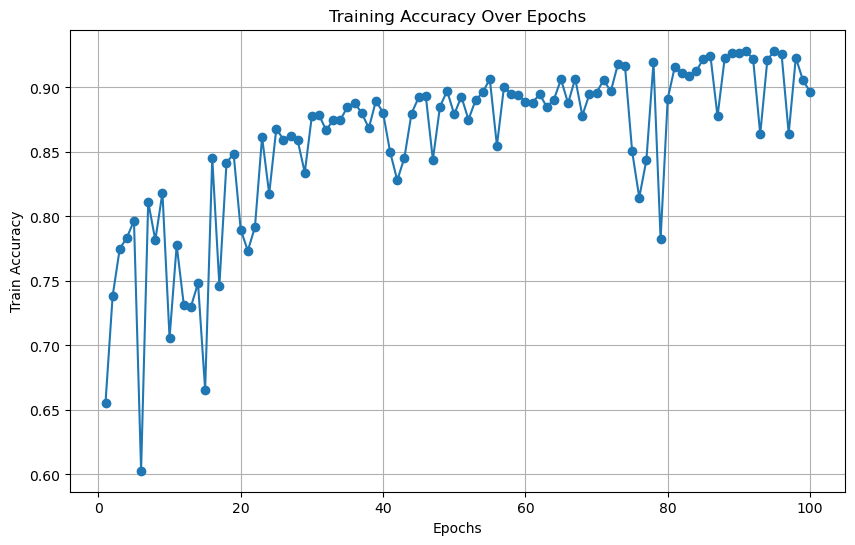

In [3]:
import numpy as np

# Training accuracies as extracted from your log
training_accuracies = [
    0.6555555555555556, 0.7382222222222222, 0.7748888888888888, 0.7835555555555556,
    0.7966666666666666, 0.6028888888888889, 0.8113333333333334, 0.7815555555555556,
    0.8184444444444444, 0.7057777777777777, 0.7777777777777778, 0.7315555555555555,
    0.73, 0.7482222222222222, 0.6657777777777778, 0.8453333333333334, 0.7464444444444445,
    0.8415555555555555, 0.8486666666666667, 0.7897777777777778, 0.7733333333333333,
    0.7917777777777778, 0.8615555555555555, 0.8175555555555556, 0.868,
    0.8595555555555555, 0.8624444444444445, 0.8588888888888889, 0.834,
    0.878, 0.8786666666666667, 0.8668888888888889, 0.8746666666666667,
    0.8748888888888889, 0.8848888888888888, 0.888, 0.8802222222222222,
    0.8684444444444445, 0.8895555555555555, 0.8804444444444445, 0.8497777777777777,
    0.828, 0.8455555555555555, 0.8797777777777778, 0.8922222222222222,
    0.8935555555555555, 0.844, 0.8851111111111111, 0.8973333333333333,
    0.8791111111111111, 0.8928888888888888, 0.8751111111111111, 0.89,
    0.8962222222222223, 0.9064444444444445, 0.8548888888888889, 0.9006666666666666,
    0.8946666666666667, 0.894, 0.8888888888888888, 0.888, 0.8948888888888888,
    0.8848888888888888, 0.8904444444444445, 0.9062222222222223, 0.8877777777777778,
    0.9068888888888889, 0.8782222222222222, 0.8946666666666667, 0.896,
    0.9057777777777778, 0.8968888888888888, 0.918, 0.9162222222222223,
    0.8504444444444444, 0.8146666666666667, 0.8435555555555555, 0.9193333333333333,
    0.7824444444444445, 0.8913333333333333, 0.916, 0.9108888888888889,
    0.9091111111111111, 0.9124444444444444, 0.9222222222222223, 0.9246666666666666,
    0.8775555555555555, 0.9224444444444444, 0.9264444444444444, 0.9266666666666666,
    0.9282222222222222, 0.922, 0.8637777777777778, 0.9213333333333333,
    0.9284444444444444, 0.9257777777777778, 0.8642222222222222, 0.9231111111111111,
    0.9055555555555556, 0.8966666666666666
]

# Plot the accuracy trend
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, marker='o', linestyle='-')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.grid()
plt.savefig('Training_87')
plt.show()

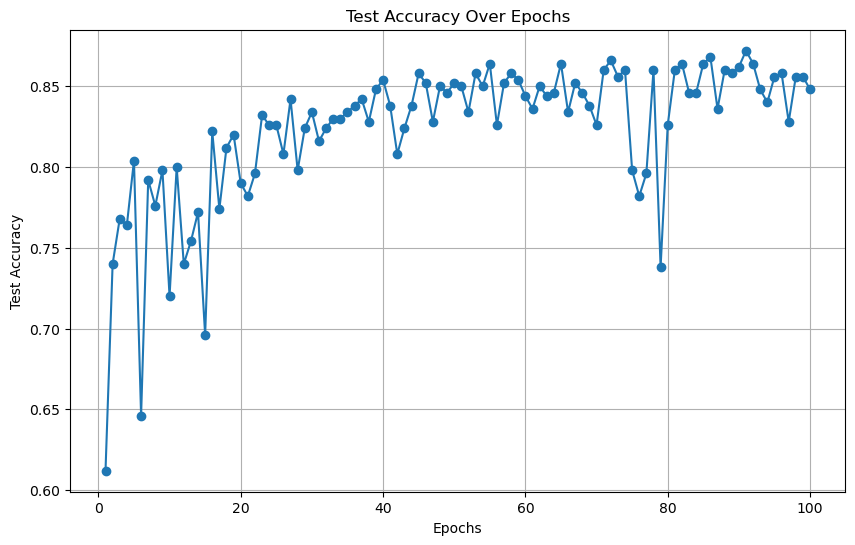

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Raw log data (replace this string with your own data if needed)
test_accuracies = [
    0.612, 0.74, 0.768, 0.764, 0.804, 0.646, 0.792, 0.776, 0.798, 0.72,
    0.8, 0.74, 0.754, 0.772, 0.696, 0.822, 0.774, 0.812, 0.82, 0.79,
    0.782, 0.796, 0.832, 0.826, 0.826, 0.808, 0.842, 0.798, 0.824, 0.834,
    0.816, 0.824, 0.83, 0.83, 0.834, 0.838, 0.842, 0.828, 0.848, 0.854,
    0.838, 0.808, 0.824, 0.838, 0.858, 0.852, 0.828, 0.85, 0.846, 0.852,
    0.85, 0.834, 0.858, 0.85, 0.864, 0.826, 0.852, 0.858, 0.854, 0.844,
    0.836, 0.85, 0.844, 0.846, 0.864, 0.834, 0.852, 0.846, 0.838, 0.826,
    0.86, 0.866, 0.856, 0.86, 0.798, 0.782, 0.796, 0.86, 0.738, 0.826,
    0.86, 0.864, 0.846, 0.846, 0.864, 0.868, 0.836, 0.86, 0.858, 0.862,
    0.872, 0.864, 0.848, 0.84, 0.856, 0.858, 0.828, 0.856, 0.856, 0.848
]

# Plot the accuracy trend
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.grid()
plt.savefig('Test_87')
plt.show()